In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

from multi_arm import Arm, k_arm_bandit

### Simulation Setup
__Bernoulli__ helper function simulates conversion.

```python
def bernoulli(p):
    return np.random.rand() < p
```

__two-sample z test__ is performed between the winner and second place arms. Algorithm is terminated if the two arms show statistical significance.

```python
def two_sample_z_test(est_p, wins, traffic, alpha=0.05):
    winner_idx = np.argmax(est_p)
    second_idx = sorted([(p, i) for i, p in enumerate(est_p)])[-2][1]
    p1, p2 = est_p[winner_idx], est_p[second_idx]
    x1, x2 = wins[winner_idx], wins[second_idx]
    n1, n2 = traffic[winner_idx], traffic[second_idx]

    p_pooled = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se
    p_val = 2*(1 - norm.cdf(abs(z)))
    
    return p_val < alpha
```

__Beta__ distribution is used to model click through rate.

```python
class Arm(object):
    def __init__(self, idx, a=1, b=1):
        self.idx = idx
        self.a = a
        self.b = b
        
    def record_success(self):
        self.a += 1
        
    def record_failure(self):
        self.b += 1
        
    def draw_ctr(self):
        return np.random.beta(self.a, self.b, 1)[0]
    
    def mean(self):
        return self.a / (self.a + self.b)
    
    def __str__(self):
        return "arm %i, a=%i, b=%i"%(self.idx, self.a, self.b)
```

__K-arm Bandit__ algorithm, terminated when winning arm beats second arm at statistical significance.

```python
def k_arm_bandit(ctrs, alpha=0.05, burn_in=100, max_iter=100000, silent=False):
    cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]

    n_arms = len(ctrs)
    arms = [Arm(idx=i) for i in range(n_arms)]
    history = [[] for _ in range(n_arms)]
    
    for i in range(max_iter):
        sample_p = [arm.draw_ctr() for arm in arms]

        idx = np.argmax(sample_p)
        ctr = ctrs[idx]
        arm = arms[idx]
        
        if bernoulli(ctr):
            arm.record_success()
        else:
            arm.record_failure()

        mean_ps = [arm.mean() for arm in arms]
        wins = [arm.a - 1 for arm in arms]
        traffic = [arm.a + arm.b - 2 for arm in arms]
        
        for j, p in enumerate(mean_ps):
            history[j].append(p)

        if i > burn_in:
            if two_sample_z_test(mean_ps, wins, traffic, alpha):
                if not silent: print("Winning arm %i beats second arm at iteration %i"%(idx, i + 1))
                break
    return idx, mean_ps, wins, traffic, history
```

### A Single Trial

In [4]:
ctrs = np.random.normal(0.2, 0.05, 10)

true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx)

alpha = 0.05
winner_idx, est_ps, wins, traffic, history = k_arm_bandit(ctrs)

true_winner_idx: 3
Winning arm 3 beats second arm at iteration 15298


In [5]:
cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history)}
df_history = pd.DataFrame(data)

df_history_ma = df_history.rolling(20).mean()

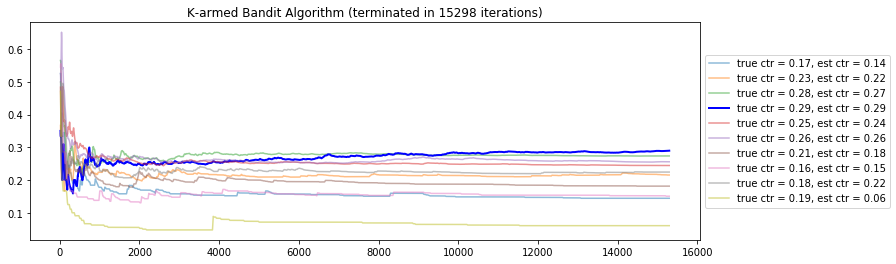

In [6]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(cols):
    if i == true_winner_idx :
        plt.plot(df_history_ma[col], lw=2, color='b')
    elif i == winner_idx:
        plt.plot(df_history_ma[col], lw=2, color='r')
    else:
        plt.plot(df_history_ma[col], alpha=0.5)

    
plt.legend(["true ctr = %.2f, est ctr = %.2f"%(true, est) for true, est in zip(ctrs, est_ps)],
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic))

plt.savefig('outputs/bandit.png')
plt.show()

In [7]:
conversion = 100 * sum(wins) / sum(traffic)
baseline = 100 * sum(np.array(ctrs) * (sum(traffic) / len(ctrs))) / sum(traffic)
print("good traffic: %i / %i = %.2f%%, baseline %.2f%%"%(sum(wins), 
                                                         sum(traffic), 
                                                         conversion,
                                                         baseline))

good traffic: 4150 / 15298 = 27.13%, baseline 22.26%


### True Positive Rate

In [8]:
start = time()

ctrs = [0.1, 0.2, 0.15]
true_winner_idx = np.argmax(ctrs)
n_trials = 100
success = 0
iters = []

for i in range(n_trials):
    winner_idx, _, _, traffic, _ = k_arm_bandit(ctrs=ctrs, alpha=0.02, silent=True)
    iters.append(sum(traffic))
    if winner_idx == true_winner_idx:
        success += 1
    if i % 10 == 0:
        print("Progress %.2f%%..."%(100 * i / n_trials), end="\r")
print("probability of finding winner: %.2f%%"%(100 * success / n_trials))

end = time()
print("time elapsed: %.2fs"%(end - start))

probability of finding winner: 74.00%
time elapsed: 78.76s


average iteration 5579.80, median 4595.00, std 4191.46


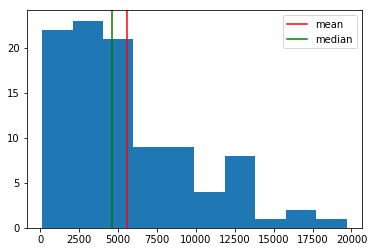

In [9]:
print("average iteration %.2f, median %.2f, std %.2f"%(np.mean(iters), np.median(iters), np.std(iters)))

plt.axvline(np.mean(iters), color='r')
plt.axvline(np.median(iters), color='g')
plt.hist(iters)

plt.legend(["mean", "median"])
plt.show()